In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


['all-dogs', 'annotation']


In [10]:
import matplotlib.pyplot as plt
import glob
import xml.etree.ElementTree as ET
import tqdm
import cv2
import zipfile


In [11]:
images_files = glob.glob(os.path.join('../input/all-dogs', 'all-dogs', '*'))
print('dog images number: ', len(images_files))

dog_types = os.listdir(os.path.join('../input/annotation', 'Annotation'))
dog_types = [dog_type[dog_type.index('-') + 1:] for dog_type in dog_types]
print('dog_types number: ', len(dog_types))
# %%
annotation_files = glob.glob(os.path.join('../input/annotation', 'Annotation', '*/*'))
print('annotation file number: ', len(annotation_files))

dog images number:  20579
dog_types number:  120
annotation file number:  20580


# Preprocess

In [12]:
dogs = []
labels = []
processed_dog_images = 0
tq = tqdm.tqdm(range(len(annotation_files)))
for i in tq:
    anno_file = annotation_files[i]
    anno_xml = ET.parse(anno_file).getroot()
    filename = os.path.basename(anno_file)
    # print('filename: ', filename)

    image = os.path.join('../input/all-dogs', 'all-dogs', filename + '.jpg')
    if not os.path.exists(image):
        print('image of this anno_file does not exist: ', anno_file, filename)
        continue
    image = cv2.imread(image)[:, :, ::-1]  # [H, W, C], BGR2RGB

    bndboxes = []
    for obj in anno_xml.iter('object'):
        name = obj.find('name').text.strip()

        if name in dog_types:
            label_idx = dog_types.index(name)
        else:
            print('filename: {}, object name: {} not in types'.format(filename, name))
            continue

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        xmax = int(bbox.find('xmax').text)
        ymin = int(bbox.find('ymin').text)
        ymax = int(bbox.find('ymax').text)

        # segmetation
        min_px = min(xmax - xmin, ymax - ymin)
        dog = image[ymin:ymin + min_px, xmin:xmin + min_px]
        dog = cv2.resize(dog, (64, 64), interpolation=cv2.INTER_AREA)

        dogs += [dog]
        labels += [label_idx]
        # img_id = target.find('filename').text[:-4]
    
    processed_dog_images += 1

tq.close()
dogs = np.array(dogs)
labels = np.array(labels)
print('all dogs shape:', dogs.shape)
print('not processed_dog_images number: ', len(images_files) - processed_dog_images)


 27%|██▋       | 5653/20580 [00:28<01:38, 151.92it/s]

image of this anno_file does not exist:  ../input/annotation/Annotation/n02105855-Shetland_sheepdog/n02105855_2933 n02105855_2933


100%|██████████| 20580/20580 [01:44<00:00, 197.78it/s]


all dogs shape: (22125, 64, 64, 3)
not processed_dog_images number:  0


In [ ]:
# np.savez_compressed(os.path.join('processed', 'dogs.npz'), dogs=dogs, labels=labels)

# if len(dogs) <= 0:
#     print('load dogs from file')
#     real_data = np.load(os.path.join('processed', 'dogs.npz'))
#     dogs = real_data['dogs']
# print('dogs shape: ', dogs.shape)

In [13]:
def remakedirs(path):
    if os.path.exists(path):
        print('rmdir ', path)
        shutil.rmtree(path)
    if not os.path.exists(path):
        os.makedirs(path)

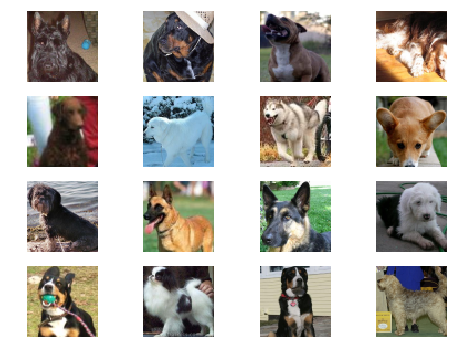

In [14]:
def random_show(images, figname=None):
    index = np.arange(len(images))
    samples = np.random.choice(index, 16)

    fig, axes = plt.subplots(4, 4, figsize=(8, 6))
    for i, axis in enumerate(axes.flatten()):
        axis.imshow(images[samples[i]])
        # axis.set_title(os.path.basename(samples[i])[:-4])
        axis.set_axis_off()
    if figname is not None:
        plt.savefig(os.path.join(config.PREPROCESS_HOME, figname))
    else:
        plt.show()

random_show(dogs)

In [15]:
import shutil
import numpy as np

import matplotlib.pyplot as plt
import random
import platform

from scipy.stats import truncnorm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from tensorboardX import SummaryWriter


In [16]:
# super params
noise_dim = 100

BATCH_SIZE = 32
NUM_WORKERS = 4

# Dataset

In [17]:
class DogDataset(Dataset):
    def __init__(self, imgs, custom_transforms):
        self.imgs = imgs
        self.custom_transforms = custom_transforms

    def rotateImage(self, image, angle):
        center = tuple(np.array(image.shape[0:2])/2)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, rot_mat, image.shape[0:2], flags=cv2.INTER_LINEAR)

    def __getitem__(self, index):
        img = self.imgs[index]

        if random.random() < 0.3:
            img = cv2.flip(img, 1)
        if random.random() < 0.5:
            angle = random.uniform(-20, 20)
            img = self.rotateImage(img, angle)
        img = self.custom_transforms(img)
        
        return img

    def __len__(self):
        return len(self.imgs)
    
custom_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = DogDataset(imgs=dogs, custom_transforms=custom_transforms)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          #   drop_last=True,
                          num_workers=4)
print('train_dataset size: ', len(train_dataset))

train_dataset size:  22125


# Train

In [18]:

class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y


class MinibatchStdDev(nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size, 1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = torch.cat([x, y], 1)
        # return the computed values:
        return y


# G

In [19]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()

        # input is Z, going into a convolution
        self.conv1 = spectral_norm(nn.ConvTranspose2d(
            nz, nfeats * 8, 4, 1, 0, bias=False))
        #self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4

        self.conv2 = spectral_norm(nn.ConvTranspose2d(
            nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        #self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8

        self.conv3 = spectral_norm(nn.ConvTranspose2d(
            nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        #self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16

        self.conv4 = spectral_norm(nn.ConvTranspose2d(
            nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        #self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32

        self.conv5 = spectral_norm(nn.ConvTranspose2d(
            nfeats * 2, nfeats, 4, 2, 1, bias=False))
        #self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64

        self.conv6 = spectral_norm(nn.ConvTranspose2d(
            nfeats, nchannels, 3, 1, 1, bias=False))
        # state size. (nchannels) x 64 x 64
        self.pixnorm = PixelwiseNorm()

    def forward(self, x):
        #x = F.leaky_relu(self.bn1(self.conv1(x)))
        #x = F.leaky_relu(self.bn2(self.conv2(x)))
        #x = F.leaky_relu(self.bn3(self.conv3(x)))
        #x = F.leaky_relu(self.bn4(self.conv4(x)))
        #x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))

        return x


# D

In [20]:

class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()

        # input is (nchannels) x 64 x 64
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        # state size. (nfeats) x 32 x 32

        self.conv2 = spectral_norm(
            nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16

        self.conv3 = spectral_norm(
            nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8

        self.conv4 = spectral_norm(
            nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        self.pixnorm = PixelwiseNorm()
        self.conv5 = spectral_norm(
            nn.Conv2d(nfeats * 8 + 1, 1, 2, 1, 0, bias=False))
        # self.dropout = nn.Dropout(0.3)
        # state size. 1 x 1 x 1

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        # x = self.dropout(x)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        # x = self.dropout(x)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        # x = self.dropout(x)
       # x = self.pixnorm(x)
        x = self.batch_discriminator(x)
        x = torch.sigmoid(self.conv5(x))
        #x= self.conv5(x)
        return x.view(-1, 1)


In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(noise_dim, 32, 3).to(device)
# print('netG: ')
# print(netG)
netD = Discriminator(3, 48).to(device)
# print('netD: ')
# print(netD)

device

device(type='cuda')

In [25]:
def plot_loss(loss_Ds, loss_Gs, epoch):
    plt.figure(figsize=(15,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(loss_Gs,label="G")
    plt.plot(loss_Ds,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.close()
    

def generate_and_save_images(epoch, gene_number=16):
    images_tensor, images = generate_images(netG, noise_dim, device, 16)

    fig = plt.figure(figsize=(8, 8))
    nrows = int(np.ceil(images.shape[0] / 4))
    for i in range(images.shape[0]):
        img = images[i, :, :, :]
        plt.subplot(nrows, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

#     plt.savefig(os.path.join(LOG_IMAGE_PATH,
#                              'epoch_{:05d}.png'.format(epoch)))
    plt.show()
    plt.close()


def generate_images(model, noise_dim, device, gene_number=16):
    # noise = torch.randn(gene_number, noise_dim, 1, 1, device=device)
    noise = truncnorm.rvs(-1, 1, size=(gene_number, noise_dim, 1, 1))
    noise = torch.from_numpy(noise).float().to(device)

    images_tensor = model(noise).to("cpu").clone().detach()
    images_tensor = (images_tensor + 1)/2.0

    images_numpy = images_tensor.numpy().transpose((0, 2, 3, 1))

    # images = (images * 255).astype(np.uint8)
    # images = np.clip(images, 0, 255)
    return images_tensor, images_numpy

In [24]:
def smooth_labels(b_size):
    # class=1 to [0.7, 1.2]
    labels = torch.full((b_size, 1), 1)
    labels = labels - 0.3 + torch.rand_like(labels) * 0.5
    return labels


def noise_labels(labels, p):
    n_select = int(p * len(labels))
    flip_index = np.random.choice([i for i in range(len(labels))], size=n_select)
    labels[flip_index] = 1 - labels[flip_index]
    labels[labels < 0 ] = 0
    return labels


[1/10] start.


100%|██████████| 692/692 [00:38<00:00, 18.03it/s]


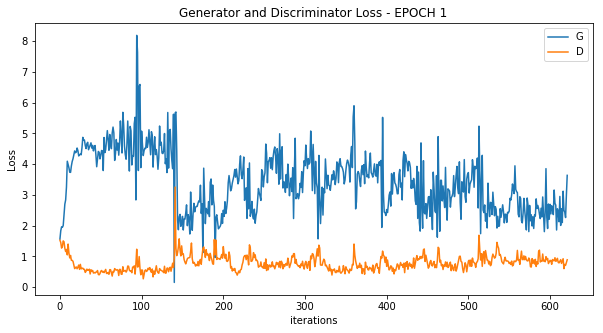

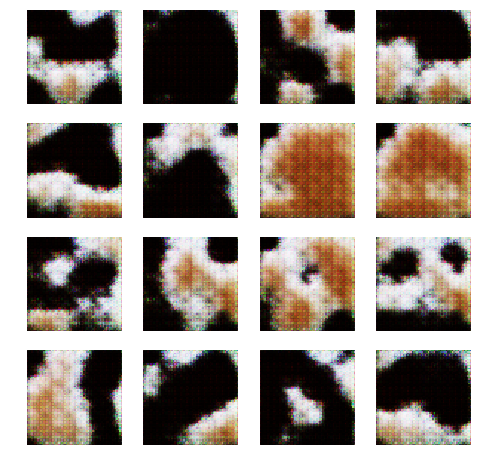

[2/10] start.


100%|██████████| 692/692 [00:36<00:00, 18.82it/s]


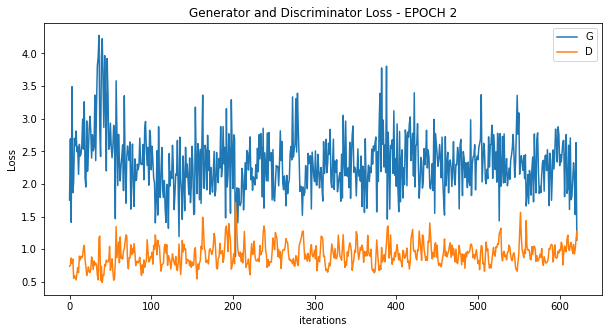

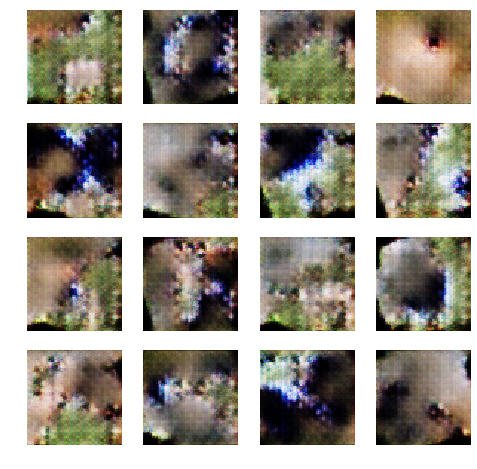

[3/10] start.


100%|██████████| 692/692 [00:36<00:00, 18.81it/s]


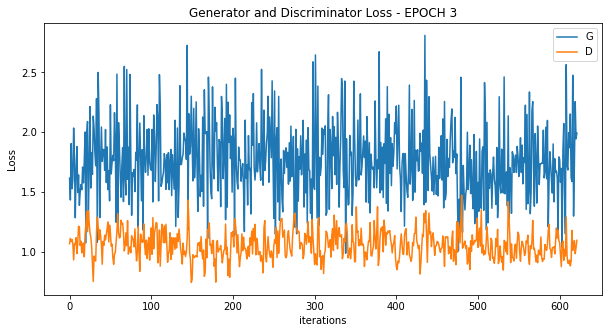

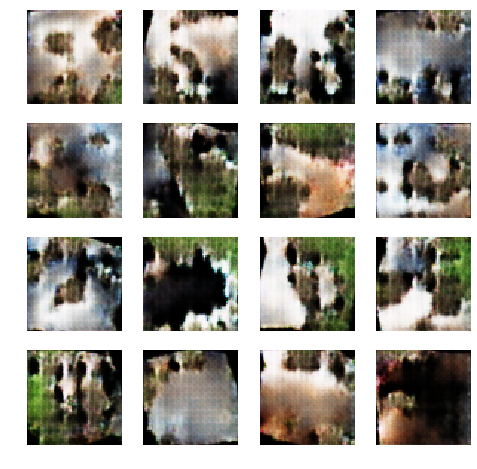

[4/10] start.


100%|██████████| 692/692 [00:36<00:00, 18.80it/s]


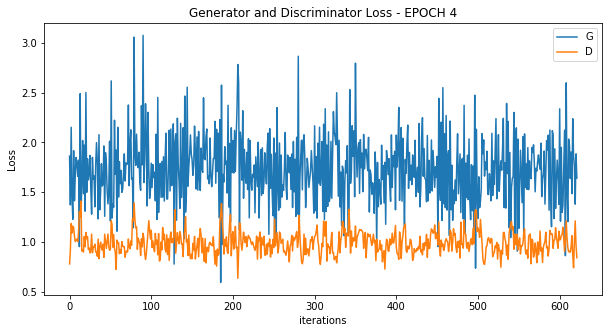

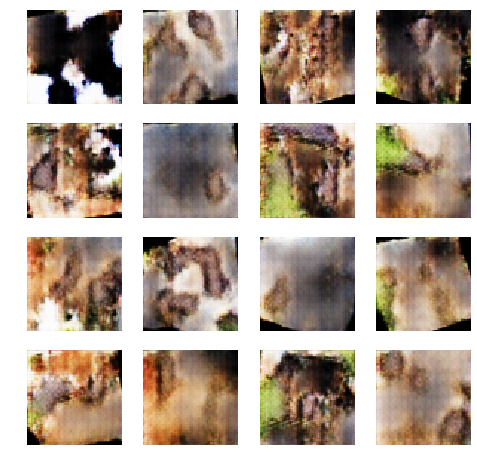

[5/10] start.


100%|██████████| 692/692 [00:36<00:00, 20.30it/s]


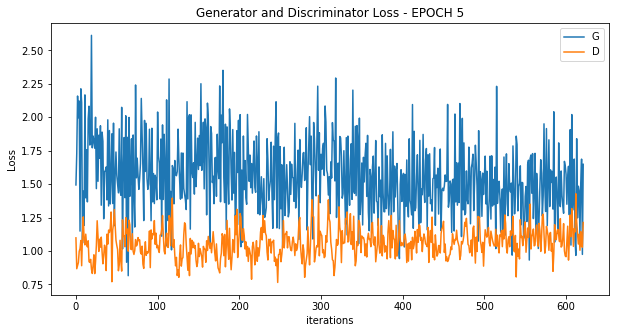

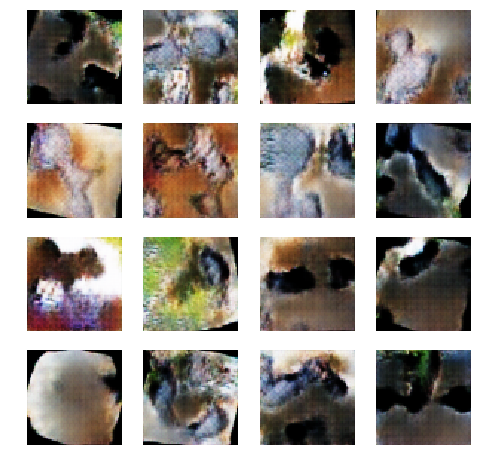

[6/10] start.


100%|██████████| 692/692 [00:36<00:00, 18.94it/s]


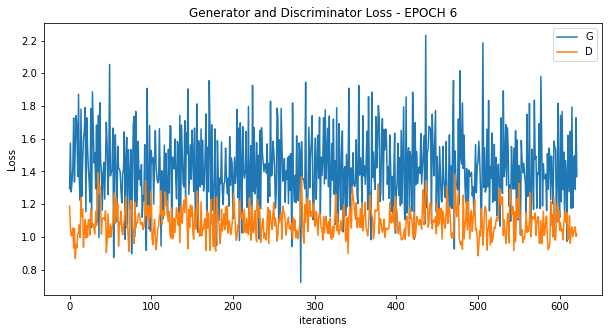

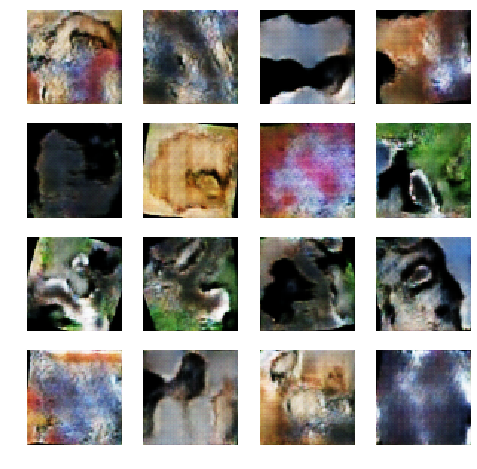

[7/10] start.


100%|██████████| 692/692 [00:36<00:00, 18.87it/s]


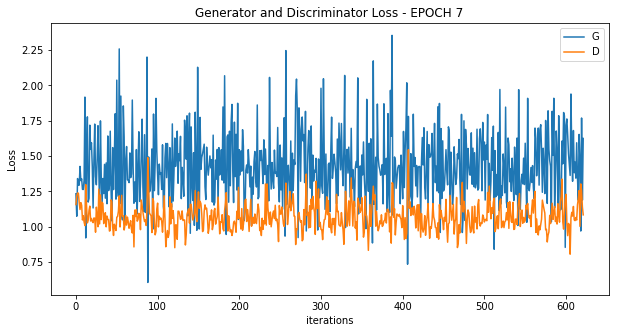

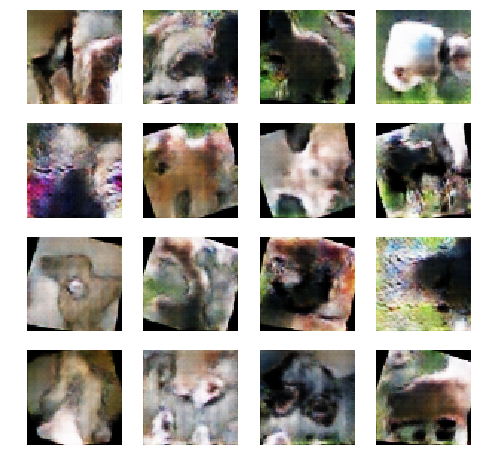

[8/10] start.


100%|██████████| 692/692 [00:36<00:00, 20.60it/s]


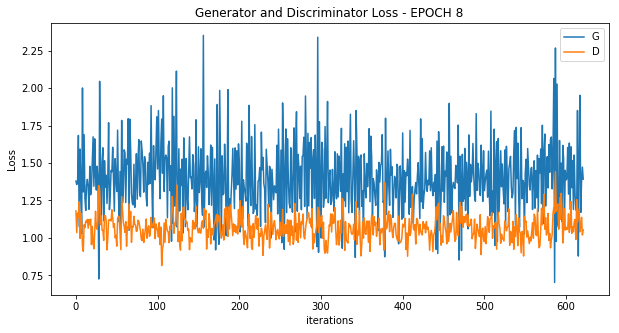

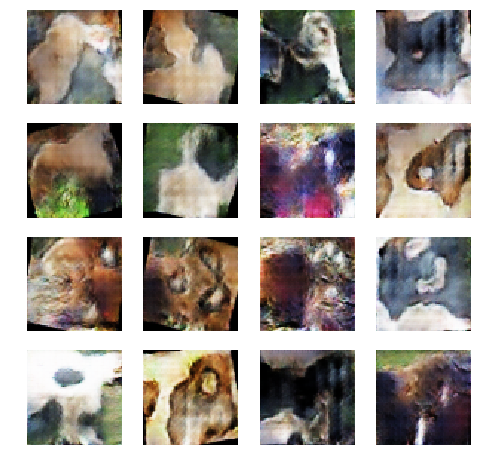

[9/10] start.


100%|██████████| 692/692 [00:36<00:00, 18.96it/s]


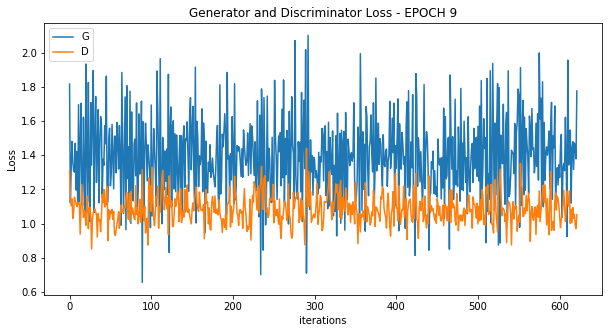

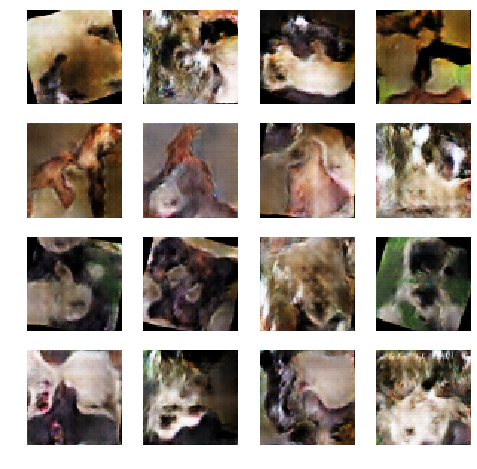

[10/10] start.


100%|██████████| 692/692 [00:35<00:00, 19.45it/s]


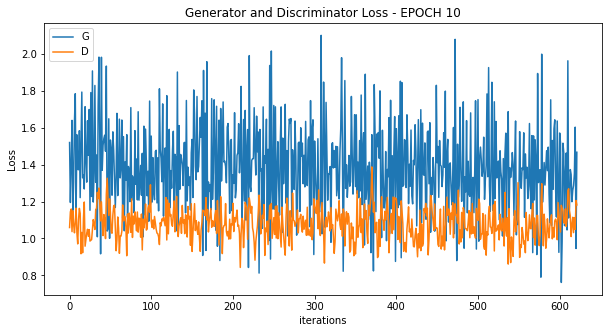

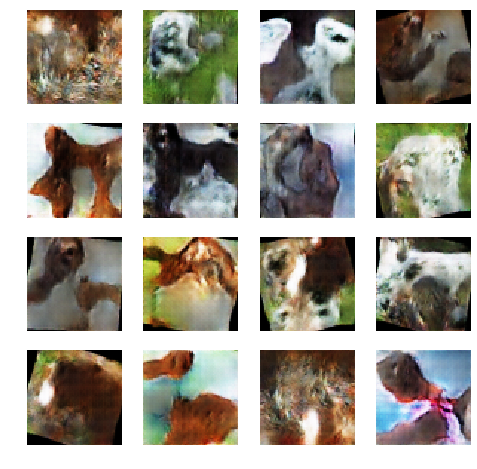

In [28]:
EPOCHS = 800

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002,
                        betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002,
                        betas=(0.5, 0.999))

update_steps = int(np.ceil(EPOCHS/200))
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD,
                                                                     T_0=update_steps, eta_min=0.00005)
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG,
                                                                     T_0=update_steps, eta_min=0.00005)

for epoch in range(EPOCHS):
    print('[%d/%d] start.' % (epoch + 1, EPOCHS))

    loss_Ds = []
    loss_Gs = []
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as t:
        for i, real_images in t:
            ############################
            # (1) Update D network
            ###########################
            netD.zero_grad()
            # add noise to inputs
            real_images = real_images + torch.randn_like(real_images) * (1/(100*(epoch+1)))
            real_images = real_images.to(device)
            b_size = real_images.shape[0]

            # Use Soft and Noisy Labels
            labels = smooth_labels(b_size)
            labels = noise_labels(labels, 0.1 / (1+epoch)).to(device)

            D_out_real = netD(real_images)
            loss_D_real = criterion(D_out_real, labels)
            loss_D_real.backward()
            D_x = D_out_real.mean().item()

            noise = torch.randn(b_size, noise_dim, 1, 1, device=device)
            fake = netG(noise)
            labels.fill_(0) + np.random.uniform(0, 0.3)

            D_out_fake = netD(fake.detach())
            loss_D_fake = criterion(D_out_fake, labels)
            loss_D_fake.backward()

            D_G_z1 = D_out_fake.mean().item()
            loss_D = loss_D_real + loss_D_fake

            optimizerD.step()
            
            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            G_out_fake = netD(fake)
            # labels = smooth_labels(b_size)
            labels.fill_(1)

            loss_G = criterion(G_out_fake, labels)
            # loss_G = (torch.mean((D_out_real - torch.mean(G_out_fake) + labels) ** 2) +
            #           torch.mean((G_out_fake - torch.mean(D_out_real) - labels) ** 2))/2
            loss_G.backward()
            optimizerG.step()
            D_G_z2 = G_out_fake.mean().item()

            if i % 20:
                loss_Ds.append(loss_D.item())
                loss_Gs.append(loss_G.item())

    # step = len(loss_D) // 5 or 1
    # print('Loss_D: {} \nLoss_G: {}'.format(loss_D[::step], loss_G[::step]))
    plot_loss(loss_Ds, loss_Gs, epoch + 1)
    generate_and_save_images(epoch + 1)


In [32]:
def save_zip(model, save_path='../output'):
    remakedirs(save_path)
    im_batch_size = 100
    n_images = 10000
    with tqdm.tqdm(total=n_images) as tq:
        for i_batch in range(0, n_images, im_batch_size):
            images_tensor, images_numpy = generate_images(
                    netG, noise_dim, device, im_batch_size)

            for i in range(images_tensor.shape[0]):
                file_name = os.path.join(save_path, f'image_{i_batch + i:05d}.png')
                vutils.save_image((images_tensor[i, :, :, :]), file_name)
                
            tq.update(im_batch_size)
            
    shutil.make_archive('images', 'zip', save_path)

In [33]:
save_zip(model=netG)

rmdir  ../output


100%|██████████| 10000/10000 [00:12<00:00, 787.04it/s]


In [34]:
!ls

__notebook_source__.ipynb  images.zip
